In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from subprocess import Popen, PIPE

# Path to the PHOENIX executable. This example requires the fp64 version of PHOENIX
PHOENIX_PATH = "../../phoenix_gpu_fp64.exe"

# Pulse loads local resources, so we need to set the working directory to the location of the executable
PHOENIX_CWD = os.path.dirname( os.path.realpath(PHOENIX_PATH) )

# Path to the data folder relative to PHOENIX_CWD
DATA_PATH = "examples/example_2/data/"

# Create results and load folders
result_path = os.path.join(PHOENIX_CWD, DATA_PATH, "results")
load_path = os.path.join(PHOENIX_CWD, DATA_PATH, "load")

# Create Target Directories
os.makedirs(result_path, exist_ok=True)
os.makedirs(load_path, exist_ok=True)

# System Parameters
grid_size = 500#1802                # Grid Size, int this case 1802x1802
x_max = 180                     # mum; Maximum Distance in one direction, meaning the grid will be from -90mum to 90mum
effective_mass = 5.864E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.005                 # Polariton Loss Rate
gamma_r = 0                     # Reservoir Loss Rate
R = 0                           # Condensation Rate
g_c = 2E-6                      # Polariton-Polariton Coupling
g_r = 0                         # Polariton-Reservoir Coupling
t_step = 0.02                  # ps; Time step of the simulation

# Pump Parameters
pump_amplitude = 5.6856                 # meV; Pump Amplitude
pump_frequency = -5.68178730684262      # Hz; Pump Frequency

# Additional Parameters not required by PHOENIX:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Matrix Generation

While PHOENIX can also generate spacial shapes via its envelope syntax, it is usually beneficial to pre-generate all required inputs. This way, we can plot and verify the inputs beforehand.

We generate an X-Y Meshgrid using numpy, fill the pump and potential matrices and plot them.


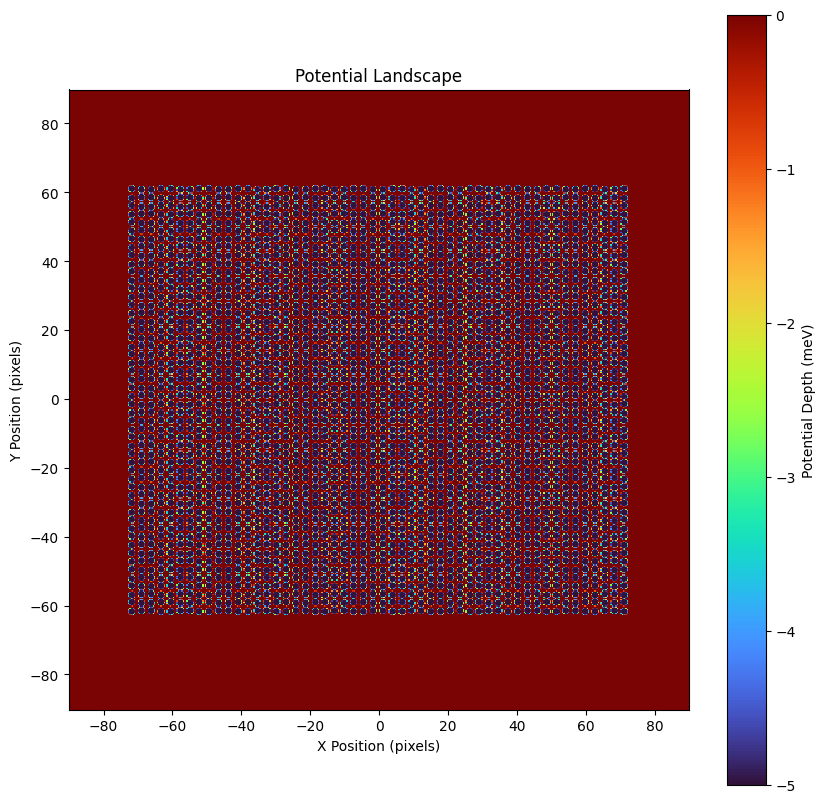

In [42]:
# Field resolution
vdxy = dx
vNx = grid_size
vNy = grid_size

# Geometric parameters (all distances from center point to center point)
vNw = 52   # Number of pillars in width/x direction
vNh = 52   # Number of pillars in height/y direction
va = 2.8   # Neighbor distance in x/w direction
vA = 2     # Distance between sub-lattices in y/h direction (between closest neighbors)
vd = 0.2   # Amplitude of the wave shift
vw = 2.15  # Width of the pillars
vV0 = 5    # Depth of the pillars (here in meV)
vshift = 3.5  # Geometrical phase shift in pi/2

vnGauss = 20  # Gauss "steepness"

# Scale geometric parameters to resolution
va = va / vdxy
vA = vA / vdxy
vd = vd / vdxy
vw = vw / vdxy

# Some helper variables
vdeltay = vA + vd * 2  # Y mirror distance between sub-lattices (between sub-lattice centers)

vxoffset = vNx / 2 - ((vNw - 1) * va) / 2
vyoffset = vNy / 2 - ((vNh - 1) * vdeltay) / 2

vMatrix = np.zeros((vNx, vNy))  # Output matrix

vGaussSize = 2 * vw  # To reduce the number of iterations in the x and y loops

for i in range(1, vNw + 1):
    vwavedelta = vd * np.cos((i + vshift) * np.pi / 2)

    for j in range(1, vNh + 1):
        vwavedelta = -vwavedelta  # Mirror wave delta for every other sub-lattice

        vxcenter = vxoffset + (i - 1) * va
        vycenter = vyoffset + (j - 1) * vdeltay + vwavedelta

        x_start = max(1, int(round(vxcenter - vGaussSize)))
        x_end = min(vNx, int(round(vxcenter + vGaussSize)))
        y_start = max(1, int(round(vycenter - vGaussSize)))
        y_end = min(vNy, int(round(vycenter + vGaussSize)))

        for x in range(x_start, x_end + 1):
            for y in range(y_start, y_end + 1):
                # Adjust indices for zero-based indexing in Python
                x_idx = x - 1
                y_idx = y - 1
                exponent = -(((x - vxcenter) ** 2 + (y - vycenter) ** 2) ** (vnGauss / 2)) / ((vw / 2) ** vnGauss)
                vMatrix[x_idx, y_idx] += -vV0 * np.exp(exponent)

# Transpose the matrix
vMatrix = vMatrix.T

# X-Y Meshgrid
x = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
y = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
X, Y = np.meshgrid(x, y)

# Visualize the matrix
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.pcolormesh(X,Y,vMatrix, cmap='turbo')
plt.colorbar(label='Potential Depth (meV)')
plt.title('Potential Landscape')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.show()


# Helper Function to save the numpy matrices into a format PHOENIX can read
def save_matrix(matrix, filename):
    header = f"SIZE {grid_size} {grid_size} {x_max} {x_max} {dx} {dx} PYTHON-GENERATED"
    # if real matrix
    if np.isrealobj(matrix):
        np.savetxt( os.path.join(load_path, filename), matrix, header=header, fmt='%.5f' )
    else:
        np.savetxt( os.path.join(load_path, filename), matrix.real, header=header, fmt='%.5f' )

# Save the potential matrix
save_matrix(vMatrix, "potential.txt")

# Execute Pulse

We create a function to generate the PHOENIX compatible commandline runstring and execute a test calculation.

We also plot the test calculation. The density for the given set of parameters should approach zero.


In [48]:
# Runstring generator
def generate_runstring( *, t_max: float ):
    # Generate Load Path relative to PHOENIX_CWD
    relative_result_path = os.path.relpath(result_path, PHOENIX_CWD).replace("\\", "/")
    relative_load_path = os.path.relpath(load_path, PHOENIX_CWD).replace("\\", "/")
    runstring = f"{PHOENIX_PATH} "
    runstring += f"--path {relative_result_path} "      # Set the output path
    runstring += f"--loadFrom {relative_load_path} "    # Set the load path
    runstring += "--input all "                         # Set the input to all
    runstring += f"--N {grid_size} {grid_size} "        # Set the grid size in points
    runstring += f"--L {x_max} {x_max} "                # Set the grid size in mum
    runstring += f"--meff {effective_mass} "            # Set the effective mass
    runstring += f"--tmax {t_max} "                     # Set the end time
    runstring += "--outEvery 1 "                        # Set sample rate to 0.5ps
    runstring += "--fftEvery 1 "                        # Set the FFT sample rate to 1ps
    runstring += f"--gc {g_c} "                         # Set the coupling constants
    runstring += f"--gr {g_r} "                         # Set the coupling constants
    runstring += f"--R {R} "                            # Set the condensation rate
    runstring += f"--gammaR {gamma_r} "                 # Set the reservoir loss rate
    runstring += f"--gammaC {gamma_c} "                 # Set the polariton loss rate
    # Add constant resonant pump with oscillation
    runstring += f"--pulse {pump_amplitude*0.001} add {15*x_max} {15*x_max} 0 0 plus 1 none gauss+noDivide time iexp 0 50E6 {pump_frequency} " 
    # Add the potential
    runstring += f"--potential load {os.path.join(relative_load_path, 'potential_plus.txt')} 1e-3 add plus " # Load the potential with a scaling of 1e-3 (meV)
    runstring += "--output wavefunction,max "
    return runstring

In [49]:
# Test Calculation, Execute PHOENIX
runstring = generate_runstring( t_max = 600 )
# Call the runstring and wait for the subprocess to finish
process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PHOENIX_CWD )
stdout, stderr = process.communicate()
# Print the output
print(stdout.decode("utf-8"))

---------------------------- Inputting System Parameters --------------------------
[ ℹ ] Halo Size for iterator 'rk4' = 4
[ ℹ ] Parsing envelope 'potential'
[ ℹ ] Queuing envelope 'potential' to be loaded from file: 'examples/example_2/data/load\potential_plus.txt'
[ ✓ ] Added Spacial Component to Envelope 'potential'
[ ℹ ] Parsing envelope 'pulse'
[ ✓ ] Added Spacial Component to Envelope 'pulse'
[ ✓ ] Added Temporal Component 'iexp' to Envelope 'pulse'
[ ℹ ] Using Reservoir: 0
[ ℹ ] Using Pumps: 0
[ ℹ ] Using Pulses: 1
[ ℹ ] Using Potentials: 1
[ ℹ ] Using Stochastic: 0
[ ℹ ] Successfully created directory 'examples/example_2/data/results/'
[ ℹ ] Creating Solver...
-------------------- Initializing Host and Device Matrices ------------------------
[ ℹ ] Initializing Halo Map...
[ ✓ ] Designated number of halo cells: 8064
[ ℹ ] Initializing Host Matrices...
[ ℹ ] Initializing Pump Envelopes...
[ ✓ ] Succesfull, designated number of pump groups: 0
[ ℹ ] Initializing Potential Envelope

### Plotting
PHOENIX saves outputs using one row per line, saving real parts first. This means, for our 200x200 complex matrices, PHOENIX will output a textfile containing a 400x200 (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`.

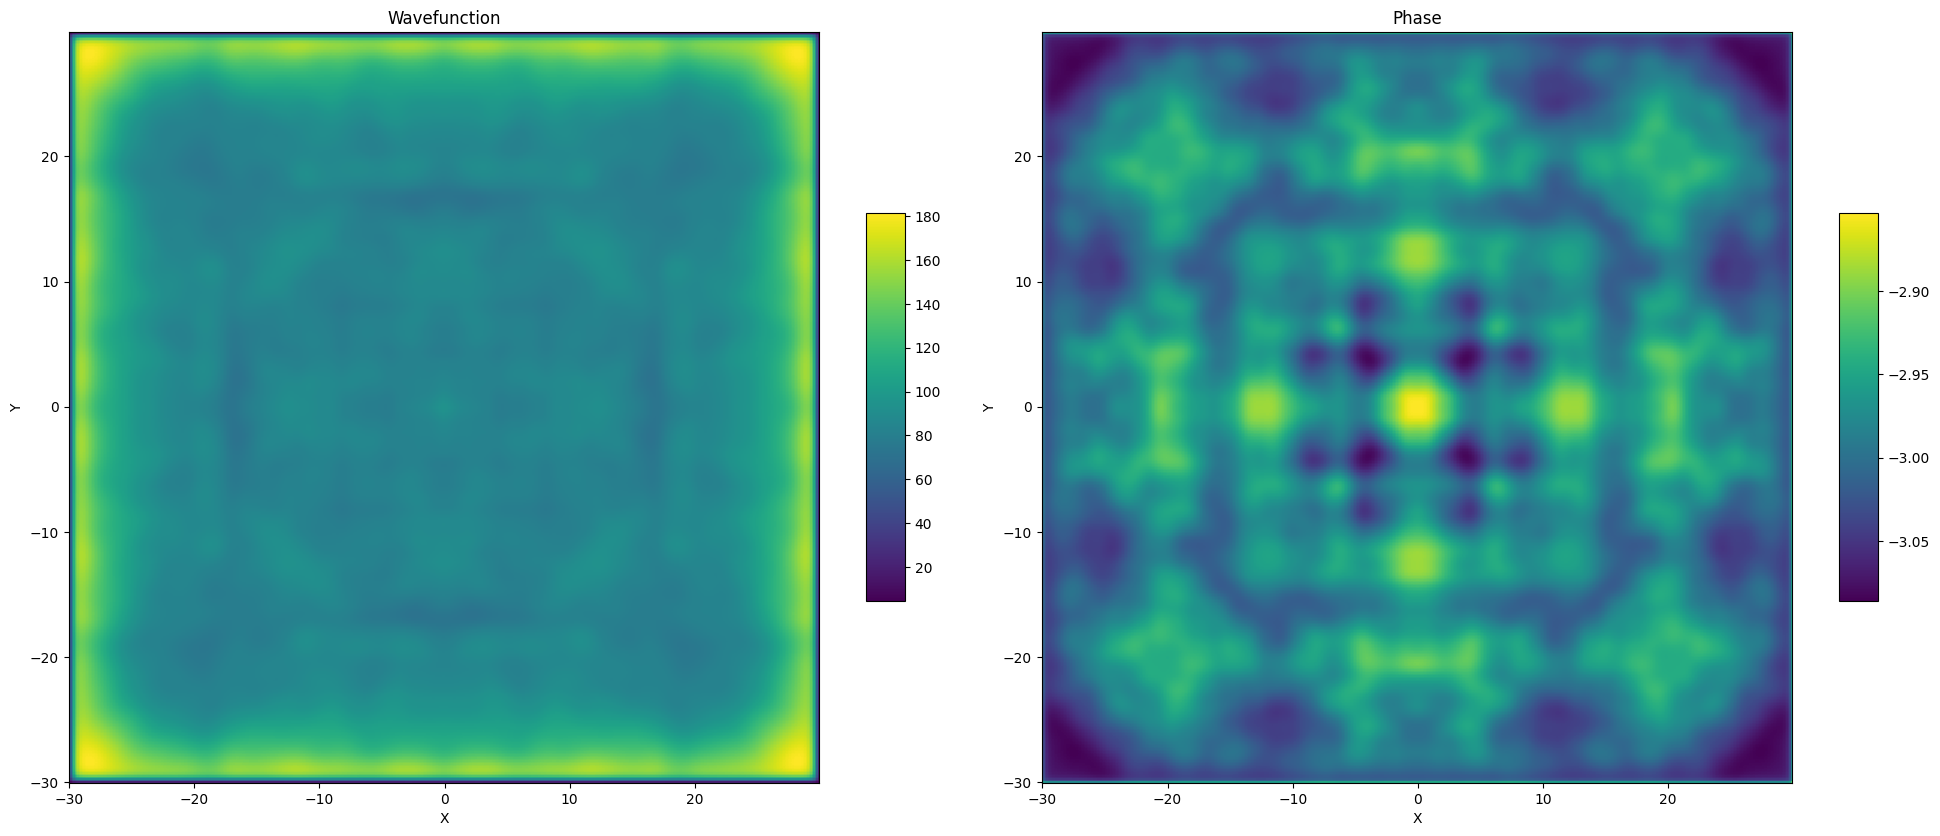

In [8]:
# Plot Results
data = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(X,Y,np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(X,Y,np.angle(psi))

for ax,plot in zip((ax1,ax2),(plt_psi,plt_phase)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

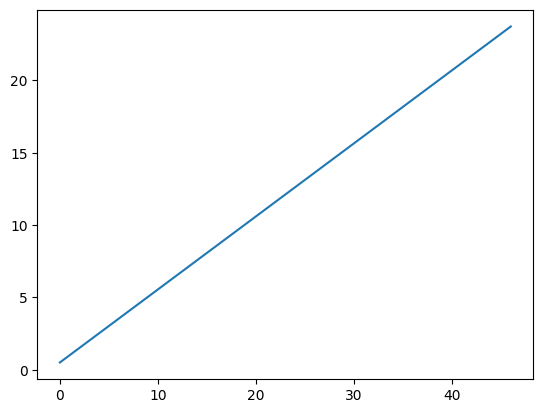

In [34]:
data_max = np.loadtxt( os.path.join(result_path, "max.txt"), unpack=True, comments="index" )

fig, ax = plt.subplots()
ax.plot(data_max[0], data_max[1])